# Seasonal Decomposition and Detrending

In [2]:
import scipy
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from pandas_datareader import data as web  

In [3]:
ticker = 'TSLA'  
data = pd.DataFrame()
data[ticker] = web.DataReader(ticker, data_source='yahoo', start='2017-1-1')['Adj Close']

data.head()

,TSLA
Date,
2017-01-03,43.397999
2017-01-04,45.397999
2017-01-05,45.349998
2017-01-06,45.801998
2017-01-09,46.256001


In [4]:
import statsmodels.api as sm

## Using Statsmodels to get the trend
The Hodrick-Prescott filter separates a time-series  y_t  into a trend  τ_t and a cyclical component  ζt

$y_t = \tau_t + \zeta_t$

The components are determined by minimizing the following quadratic loss function

$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$

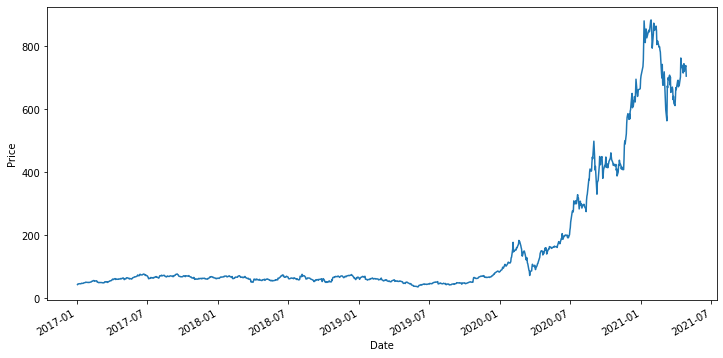

In [5]:
data['TSLA'].plot(figsize=(12,6))
plt.ylabel("Price");

### Hodrick–Prescott decomposition is a mathematical tool used to remove the cyclical component of a time series from raw data

In [6]:
cycle, trend = sm.tsa.filters.hpfilter(data.TSLA)
# trend = trend.values

Trend + Cycle = input signal


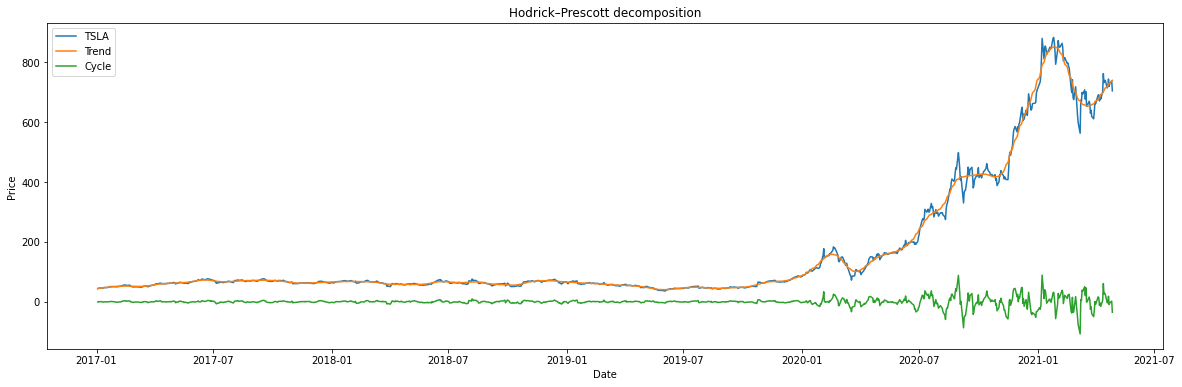

In [7]:
print('Trend + Cycle = input signal')
plt.figure(figsize=(20,6))
plt.plot(data.TSLA, label = "TSLA")
plt.plot(trend, label = "Trend")
plt.plot(cycle, label = "Cycle")

plt.legend()
plt.ylabel("Price")
plt.xlabel("Date")
plt.title("Hodrick–Prescott decomposition");

## Let's try statsmodels.tsa.seasonal import seasonal_decompose

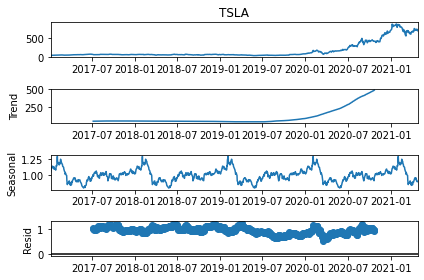

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
tsla = data.TSLA

result = seasonal_decompose(tsla, model='multiplicative', period = 252);
_ = result.plot()

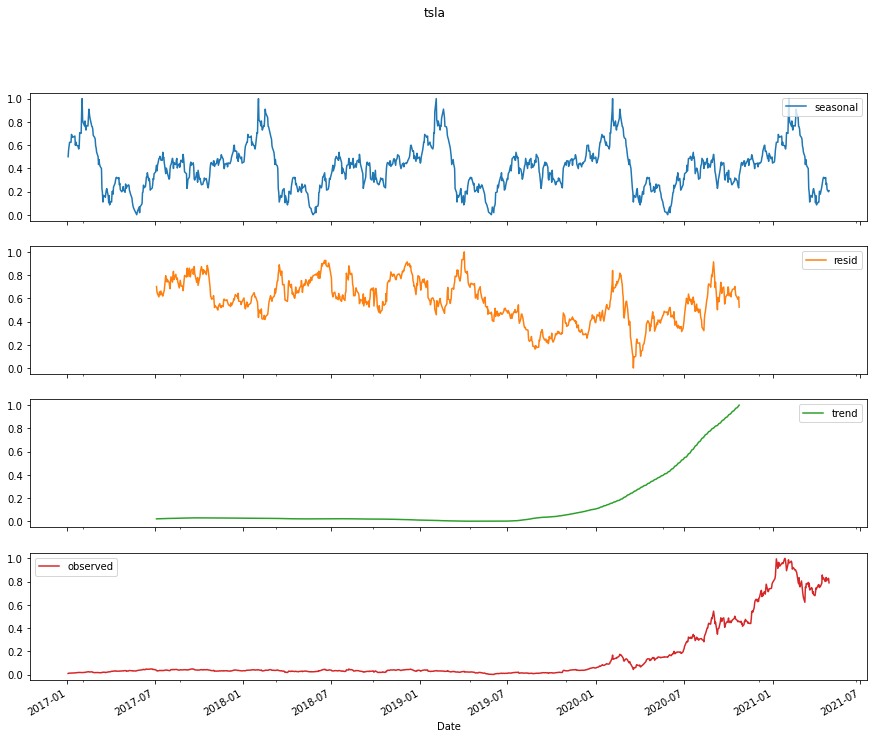

In [9]:
df = pd.DataFrame({
    "seasonal":result.seasonal.values,
    "resid":result.resid,
    "trend":result.trend,
    "observed":data.TSLA})

# df = df.fillna(df.mean())
# df['seasonal'] = MinMaxScaler().fit_transform(df[['seasonal']])
# df['resid'] = MinMaxScaler().fit_transform(df[['resid']])
# df['observed'] = MinMaxScaler().fit_transform(df[['observed']])
# df['trend'] = MinMaxScaler().fit_transform(df[['trend']])

df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df.plot(title="tsla",figsize=(15,12),subplots=(4,1));

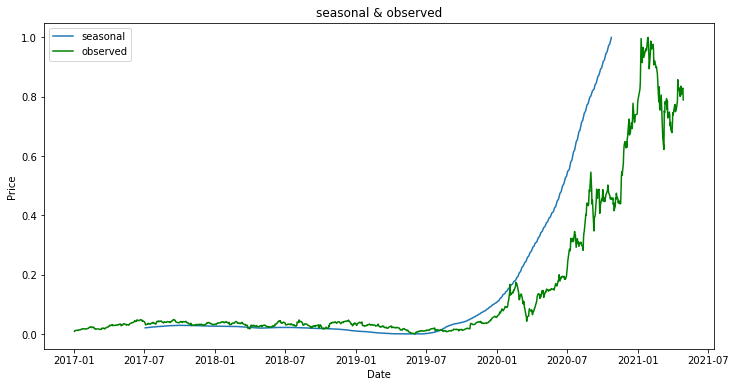

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.trend, label = 'seasonal')
plt.plot(df.observed, label = 'observed', color='green')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.title("seasonal & observed");

In [11]:
corr, pVal = scipy.stats.spearmanr(df.seasonal,df.observed) # pearsonr

print(f"Corr is: {corr:.2f}")
print(f"pVal is: {pVal:.2f}")

if (pVal <  0.05):
   print("P-value is significant! There is a correlation, ", pVal)
   print("Given our significance level of α = 0.05, There is sufficient evidence to conclude that there is a significant linear relationship between x and y because the correlation coefficient is significantly different from 0.")

Corr is: 0.17
pVal is: 0.00
P-value is significant! There is a correlation,  8.153500339837117e-09
Given our significance level of α = 0.05, There is sufficient evidence to conclude that there is a significant linear relationship between x and y because the correlation coefficient is significantly different from 0.


## Let's try subtracting the {Linear Reg, Polynomial Reg, Nth-MA}  

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = np.array(range(data.TSLA.shape[0])).reshape(-1,1)
y = data.TSLA

def ploy(degree = 2):
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = LinearRegression()
    clf.fit(X_, y)
    return clf.predict(X_)

OLS_pred    = ploy(1)
POLY_pred_2 = ploy(2)
POLY_pred_9 = ploy(9)

MA_40 = data.TSLA.rolling(40).mean().fillna(200).values
# MA_80 = data.TSLA.rolling(80).mean().fillna(200).values

TSLA = data.TSLA.values

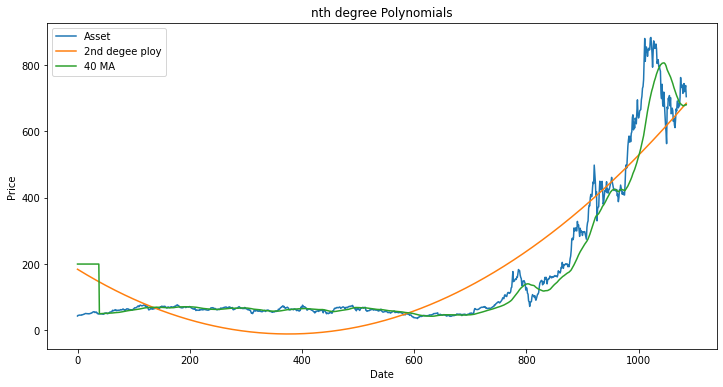

In [13]:
plt.figure(figsize=(12,6))
plt.plot(TSLA, label = 'Asset')
# plt.plot(OLS_pred, label = 'OLS')
plt.plot(POLY_pred_2, label = '2nd degee ploy')
# plt.plot(POLY_pred_9, label = '9th degee ploy')
plt.plot(MA_40, label = '40 MA')


plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.title("nth degree Polynomials");

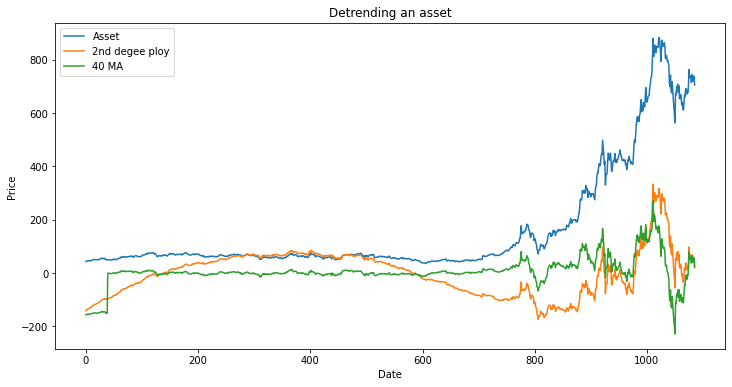

In [14]:
plt.figure(figsize=(12,6))
plt.plot(TSLA, label = 'Asset')
# plt.plot(TSLA - OLS_pred, label = 'OLS')
plt.plot(TSLA - POLY_pred_2, label = '2nd degee ploy')
# plt.plot(TSLA - POLY_pred_9, label = '9th degee ploy')
plt.plot(TSLA - MA_40, label = '40 MA')

# tester for MA 
# plt.plot(TSLA - data.TSLA.rolling(80).mean().fillna(TSLA.min()).values, label = 'MA')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.title("Detrending an asset");

In [15]:
print(np.mean(TSLA))
print(np.std(TSLA))

163.56196657114046
206.87549152859228


In [16]:
print(np.mean(TSLA - MA_40))
print(np.std(TSLA - MA_40))

6.202396366477671
52.31165363928693
